In [1]:
import torch
import gc
import os
from fft_conv_pytorch import fft_conv, FFTConv2d

# Deconvolution Related Functions

In [2]:
def fft_convolve_images(image, kernel_stack, summation = False):
    # Using this will result in worse performance. Only use this when you are out of memory.
    
    # image is the image to be convolved
    # kernel_stack is the stack of kernels to be convolved with the image
    
    # The image and the kernel stack should be the same size
    # The kernel stack should be in the format [depth, x, y]
    return_tensor = torch.fft.ifftshift(torch.fft.ifft2(torch.mul(torch.fft.fft2(image), torch.fft.fft2(torch.div(kernel_stack, torch.sum(kernel_stack, dim = (1,2)).unsqueeze(1).unsqueeze(2)))), dim = (1,2))) # Convolve the image with the kernel stack
        
    if summation == True:
        return_tensor = torch.sum(return_tensor, 0) # Sum all of the convolutions
    
    return return_tensor

In [3]:
def richardson_lucy(original_image, f, b, iterations, device):
    # e_i is the image to be deconvolved
    # oringinal_image is the image that was convolved with the kernel
    # f is the forward projector
    # b is the backward projector
    with torch.no_grad():
        kernel_size_f = f.shape[0]
        func1 = torch.nn.Conv2d(1, 1, kernel_size=kernel_size_f, stride=1, padding = 'same', device = device)
        func1.weight = f
        
        kernel_size_b = b.shape[0]
        func2 = torch.nn.Conv2d(1, 1, kernel_size=kernel_size_b, stride=1, padding = 'same', device = device)
        func2.weight = b
        
        e_i = func2(original_image.detach())
        
        for i in range(int(iterations)):
            denom = func1(e_i)
            fraction = torch.div(original_image.detach(), denom)
            
            del denom
            gc.collect()
            if device == 'cuda':
                torch.cuda.empty_cache()
                
            factor = func2(fraction)
            
            del fraction
            gc.collect()
            if device == 'cuda':
                torch.cuda.empty_cache()
            
            e_i = torch.mul(e_i, factor)
            
            del factor
            gc.collect()
            if device == 'cuda':
                torch.cuda.empty_cache()
    
    return e_i

In [4]:
def rl_deconv(frames, PSF, PSF_bp, device, iterations = 10, path = r"./", cpu_option = 'cpu', temp_storage = False, tolerance = 1e-4):
    # Take the whole lenslet image & the whole PSFs and apply the Richardson-Lucy algorithm to it
    # Frames should be in the format of [time, x, y]
    # PSF should be in the format of [depths, x, y]
    # Output should be in the format of [time, depth, x, y]
    # cpu_option is the device that does the division and the multiplication.
    # temp_storage dictates how the temporary storage is handled. If it is set to True, then the temporary storage is saved to the disk. If it is set to False, then the temporary storage is saved to the RAM.
    
    # So, FFTConv2D CAN work, it's just that we have to process one channel at a time and empty out cache after each iteration.
    # The problem is that the memory is not being freed up after each iteration. This is a problem with the way that the memory is being handled.
    
    with torch.autocast(device_type=device):
        with torch.no_grad():
            conv2d = FFTConv2d(1, 1, kernel_size = (len(PSF_bp[0,:,0]), len(PSF_bp[0,0,:])), stride = 1, padding = 'same', bias = False).to(device)
            
            print("Initializing the convolutional layer for the Richardson-Lucy algorithm")
            
            if type(frames) != torch.Tensor:
                frames = torch.tensor(frames)
                gc.collect()
            
            if frames.dtype != torch.float32:
                frames = frames.to(torch.float32)
                gc.collect()
                
            if device == 'cuda':
                torch.cuda.empty_cache()
            
            for k in range(len(frames[:,0,0])):
                # Each time step
                #print("Creating projected volume and image for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
                
                original_image = frames[k,:,:].clone().detach().to(cpu_option) # Format: (x,y)
                projected_volume = torch.empty([len(PSF[:,0,0]), len(PSF[0,:,0]), len(PSF[0,0,:])], dtype = torch.float32).detach().to(cpu_option) # Format: (depth, x,y)
                projected_image = original_image.clone().detach() # Format: (x,y), we do not want the original image to be modified
                
                print("Finished initialization for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])) + ", now creating the projected volume and image for the frame")
                
                gc.collect()
                if device == 'cuda':
                    torch.cuda.empty_cache()
                
                for i in range(len(PSF[:,0,0])): # Save the projected volume to the CPU memory, but use gpu to do the calculations (if possible)
                    #print("Now creating projected volume " + str(i+1) + " out of " + str(len(PSF[:,0,0])) + " for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
                    conv2d.weights = torch.nn.parameter.Parameter(torch.div(PSF_bp[i,:,:].detach(), torch.sum(PSF_bp[i,:,:].detach())).detach().to(device).unsqueeze(0).unsqueeze(0))
                    temp_vol = torch.clamp(conv2d(original_image.detach().unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).squeeze(0), min = tolerance)
                    
                    print(str('PSF_bp') + str(torch.isnan(PSF_bp[i,:,:]).any())) # no nans
                    print(str('original_image') + str(torch.isnan(original_image).any())) # no nans
                    
                    if temp_storage == True:
                        torch.save(temp_vol, path +'tempvol'+ '_' + str(i) + '.pt')
                        
                    if temp_storage == False:
                        print(str(torch.isnan(temp_vol).any()) + str(i) + str('start')) # NANS FOUND
                        projected_volume[i,:,:] = temp_vol.to(cpu_option)
                        
                    del temp_vol
                    gc.collect()

                    if device == 'cuda':
                        torch.cuda.empty_cache()
                
                print(str(torch.isnan(projected_volume).any()) + str(k))
                print("Finished creating the projected volume and image for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])) + ", now processing the iterations")
                
                for j in range(iterations):
                    print("Now processing iteration " + str(j+1) + " out of " + str(iterations) + " for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
                    # Schema:
                    # Calculate the projected image (Sum of o_i * PSF)
                    # Divide the original image by the projected image (original_image / projected_image), (should be done on the cpu?)                
                    # Convolve the ratio with the backward projector (ratio * PSF_bp)
                    # Multiply the original image by the result of the convolution (original_image * result)
                    # Repeat until the iterations are done
                    
                    # Denominator results in a projected image
                    
                    for l in range(len(PSF[:,0,0])):
                        conv2d.weight = torch.nn.parameter.Parameter(torch.div(PSF[l,:,:].detach(), torch.sum(PSF[l,:,:].detach())).detach().to(device).unsqueeze(0).unsqueeze(0))
                        
                        if temp_storage == True:
                            temp_vol = torch.load(path + 'tempvol' + '_' + str(l) + '.pt').to(device)
                            projected_image += torch.clamp(conv2d(temp_vol.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).to(cpu_option), min = tolerance)
                            del temp_vol
                            gc.collect()
                        
                        if temp_storage == False:
                            projected_image += torch.div(torch.clamp(conv2d(projected_volume[i,:,:].unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).squeeze(0).to(cpu_option),min = tolerance), len(PSF[:,0,0]))
                            print(str(torch.isnan(projected_image[i,:,:]).any()) + str(l))
                        
                        if device == 'cuda':
                            torch.cuda.empty_cache()
                    
                    # We have the projected image, now take the ratio. The projected image is in 'device'.
                    
                    image_ratio = torch.nan_to_num(torch.div(original_image,projected_image).to(cpu_option), 1) # If the projected image is 0, then the ratio is 1
                    
                    # Convolve the ratio with the backward projector
                    
                    factor = torch.empty([len(PSF[:,0,0]),len(PSF[0,:,0]), len(PSF[0,0,:])], dtype = torch.float32).to(cpu_option) # Format: (depth,x,y)\
                    
                    for l in range(len(PSF_bp[:,0,0])):
                        #print("Now creating multiplying factor " + str(i+1) + " out of " + str(len(PSF_bp[:,0,0])) + " for iteration " + str(j+1) + " out of " + str(iterations) + " for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
                        conv2d.weight = torch.nn.parameter.Parameter(torch.div(PSF_bp[l,:,:].detach(), torch.sum(PSF_bp[l,:,:].detach())).detach().to(device).unsqueeze(0).unsqueeze(0).to(device))
                        factor_results = torch.clamp(conv2d(image_ratio.to(device).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).to(cpu_option), min = tolerance)
                        print(str(torch.isnan(factor_results).any()) + str(l))
                        
                        if temp_storage == True:
                            torch.save(factor_results, path + 'factor' + '_' + str(l) + '.pt')
                            
                        elif temp_storage == False:
                            factor[l,:,:] = factor_results.to(cpu_option)
                        
                        del factor_results
                        gc.collect()
                        
                    del image_ratio # We don't need this anymore
                    gc.collect()
                    
                    if device == 'cuda':
                        torch.cuda.empty_cache()
                    
                    # We have the new factor, now multiply it by the original volume
                    if temp_storage == True:
                        for m in range(len(PSF[:,0,0])):
                            temp_vol = torch.load(path + 'tempvol' + '_' + str(m) + '.pt').to(cpu_option)
                            temp_factor = torch.load(path + 'factor' + '_' + str(m) + '.pt').to(cpu_option)
                            torch.save(torch.mul(temp_vol, temp_factor), path +'tempvol'+ '_' + str(m) + '.pt')
                            
                            del temp_vol, temp_factor
                            gc.collect()
                            
                            if device == 'cuda':
                                torch.cuda.empty_cache()
                    
                    if temp_storage == False:
                        projected_volume[:,:,:] = torch.mul(projected_volume[:,:,:].to(cpu_option), factor[:,:,:].to(cpu_option)).to(cpu_option)
                    print(str(torch.isnan(projected_volume).any()))
                
                print("Finished processing frame " + str(k+1) + " out of " + str(len(frames[:,0,0])) + ", now saving the results")
                
                if temp_storage == False:
                    torch.save(projected_volume, path + str(k) + '.pt')
                    
                for m in range(len(PSF[:,0,0])):
                    if temp_storage == True:
                        os.rename(path + 'tempvol' + '_' + str(m) + '.pt', path + str(k) + '_' + str(m) + '.pt')
            
            del projected_volume, projected_image, original_image, factor
            gc.collect()
            
            if device == 'cuda':
                torch.cuda.empty_cache()
            
    return None

In [5]:
def rl2_deconv(frames, PSF, PSF_bp, device, iterations = 10, path = r"./", cpu_option = 'cpu', temp_storage = False, tolerance = 1e-4):
    # Take the whole lenslet image & the whole PSFs and apply the Richardson-Lucy algorithm to it
    # Frames should be in the format of [time, x, y]
    # PSF should be in the format of [depths, x, y]
    # Output should be in the format of [time, depth, x, y]
    # cpu_option is the device that does the division and the multiplication.
    # temp_storage dictates how the temporary storage is handled. If it is set to True, then the temporary storage is saved to the disk. If it is set to False, then the temporary storage is saved to the RAM.
    
    # So, FFTConv2D CAN work, it's just that we have to process one channel at a time and empty out cache after each iteration.
    # The problem is that the memory is not being freed up after each iteration. This is a problem with the way that the memory is being handled.
    
    with torch.autocast(device_type=device):
        with torch.no_grad():
            conv2d = FFTConv2d(1, 1, kernel_size = (len(PSF_bp[0,:,0]), len(PSF_bp[0,0,:])), stride = 1, padding = 'same', bias = False).to(device)
            
            print("Initializing the convolutional layer for the Richardson-Lucy algorithm")
            
            if type(frames) != torch.Tensor:
                frames = torch.tensor(frames)
                gc.collect()
            
            if frames.dtype != torch.float32:
                frames = frames.to(torch.float32)
                gc.collect()
                
            if device == 'cuda':
                torch.cuda.empty_cache()
            
            for k in range(len(frames[:,0,0])):
                # Each time step
                #print("Creating projected volume and image for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
                
                original_image = frames[k,:,:].clone().detach().to(cpu_option) # Format: (x,y)
                projected_volume = torch.empty([len(PSF[:,0,0]), len(PSF[0,:,0]), len(PSF[0,0,:])], dtype = torch.float32).detach().to(cpu_option) # Format: (depth, x,y)
                projected_image = original_image.clone().detach() # Format: (x,y), we do not want the original image to be modified
                
                print("Finished initialization for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])) + ", now creating the projected volume and image for the frame")
                
                gc.collect()
                if device == 'cuda':
                    torch.cuda.empty_cache()
                
                for i in range(len(PSF[:,0,0])): # Save the projected volume to the CPU memory, but use gpu to do the calculations (if possible)
                    #print("Now creating projected volume " + str(i+1) + " out of " + str(len(PSF[:,0,0])) + " for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
                    conv2d.weights = torch.nn.parameter.Parameter(torch.div(PSF_bp[i,:,:].detach(), torch.sum(PSF_bp[i,:,:].detach())).detach().to(device).unsqueeze(0).unsqueeze(0))
                    temp_vol = torch.clamp(conv2d(original_image.detach().unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).squeeze(0), min = tolerance)
                    
                    print(str(temp_vol) + str(torch.isnan(temp_vol).any()) + str(i))
                    print(str(original_image) + str(torch.isnan(temp_vol).any()) + str(i))
                    
                    if temp_storage == True:
                        torch.save(temp_vol, path +'tempvol'+ '_' + str(i) + '.pt')
                        
                    if temp_storage == False:
                        projected_volume[i,:,:] = temp_vol.to(cpu_option)
                
                    del temp_vol
                    gc.collect()

                    if device == 'cuda':
                        torch.cuda.empty_cache()
                    
                #### FOR TESTING PURPOSES
                
                torch.save(projected_volume, path + 'projected_volume' + '_' + str(k) + '.pt')
                
                ##### FOR TESTING PURPOSES
                
                print("Finished creating the projected volume and image for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])) + ", now processing the iterations")
                
                for j in range(iterations):
                    print("Now processing iteration " + str(j+1) + " out of " + str(iterations) + " for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
                    # Schema:
                    # Calculate the projected image (Sum of o_i * PSF)
                    # Divide the original image by the projected image (original_image / projected_image), (should be done on the cpu?)                
                    # Convolve the ratio with the backward projector (ratio * PSF_bp)
                    # Multiply the original image by the result of the convolution (original_image * result)
                    # Repeat until the iterations are done
                    
                    # Denominator results in a projected image
                    
                    for l in range(len(PSF[:,0,0])):
                        conv2d.weight = torch.nn.parameter.Parameter(torch.div(PSF[l,:,:].detach(), torch.sum(PSF[l,:,:].detach())).detach().to(device).unsqueeze(0).unsqueeze(0))
                        
                        if temp_storage == True:
                            temp_vol = torch.load(path + 'tempvol' + '_' + str(l) + '.pt').to(device)
                            projected_image += torch.nan_to_num(torch.clamp(conv2d(temp_vol.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).to(cpu_option), tolerance),0)
                            del temp_vol
                            gc.collect()
                        
                        projected_image += conv2d(projected_volume[l,:,:].unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).squeeze(0).to(cpu_option)
                        if temp_storage == False:
                            projected_image += torch.nan_to_num(torch.clamp(conv2d(projected_volume[l,:,:].unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).squeeze(0).to(cpu_option), min = tolerance))
                        
                        if device == 'cuda':
                            torch.cuda.empty_cache()
                    
                    ##### FOR TESTING PURPOSES
                    torch.save(projected_image, path + 'projected_image' + '_' + str(k) + '.pt')
                    ##### FOR TESTING PURPOSES
                        
                    # We have the projected image, now take the ratio. The projected image is in 'device'.
                    
                    image_ratio = torch.nan_to_num(torch.div(original_image,projected_image).to(cpu_option), 1) # If the projected image is 0, then the ratio is 1
                    
                    
                    ##### TESTING PURPOSES 
                    torch.save(image_ratio, path + 'image_ratio' + '_' + str(k) + '.pt')
                    ###### TESTING PURPOSES
                    
                    # Convolve the ratio with the backward projector
                    
                    factor = torch.empty([len(PSF[:,0,0]),len(PSF[0,:,0]), len(PSF[0,0,:])], dtype = torch.float32).to(cpu_option) # Format: (depth,x,y)\
                    
                    for l in range(len(PSF_bp[:,0,0])):
                        #print("Now creating multiplying factor " + str(i+1) + " out of " + str(len(PSF_bp[:,0,0])) + " for iteration " + str(j+1) + " out of " + str(iterations) + " for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
                        conv2d.weight = torch.nn.parameter.Parameter(torch.div(PSF_bp[l,:,:].detach(), torch.sum(PSF_bp[l,:,:].detach())).detach().to(device).unsqueeze(0).unsqueeze(0).to(device))
                        factor_results = conv2d(image_ratio.to(device).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).to(cpu_option)
                        
                        ##### TESTING PURPOSES
                        torch.save(factor_results, path + 'factor' + '_' + str(l) + '.pt')
                        ##### TESTING PURPOSES
                        
                        if temp_storage == True:
                            torch.save(factor_results, path + 'factor' + '_' + str(l) + '.pt')
                            
                        elif temp_storage == False:
                            factor[l,:,:] = factor_results.to(cpu_option)
                        
                        del factor_results
                        gc.collect()
                    
                    del image_ratio # We don't need this anymore
                    gc.collect()
                    
                    if device == 'cuda':
                        torch.cuda.empty_cache()
                    
                    torch.save(torch.mul(temp_vol, temp_factor), path +'tempvol'+ '_' + str(i) + '.pt')
                    
                    # We have the new factor, now multiply it by the original volume
                    if temp_storage == True:
                        for i in range(len(PSF[:,0,0])):
                            temp_vol = torch.load(path + 'tempvol' + '_' + str(i) + '.pt').to(cpu_option)
                            temp_factor = torch.load(path + 'factor' + '_' + str(i) + '.pt').to(cpu_option)
                            
                            del temp_vol, temp_factor
                            gc.collect()
                            
                            if device == 'cuda':
                                torch.cuda.empty_cache()
                    
                    if temp_storage == False:
                        projected_volume[:,:,:] = torch.mul(projected_volume[:,:,:].to(cpu_option), factor[:,:,:].to(cpu_option)).to(cpu_option)
                
                print("Finished processing frame " + str(k+1) + " out of " + str(len(frames[:,0,0])) + ", now saving the results")
                
                if temp_storage == False:
                    torch.save(projected_volume, path + str(k) + '.pt')
                    
                for i in range(len(PSF[:,0,0])):
                    if temp_storage == True:
                        os.rename(path + 'tempvol' + '_' + str(i) + '.pt', path + str(k) + '_' + str(i) + '.pt')
            
            del projected_volume, projected_image, original_image, factor
            gc.collect()
            
            if device == 'cuda':
                torch.cuda.empty_cache()
            
    return None

# Go get 'em

In [6]:
results = rl_deconv(torch.load(r'./test_images/Frames/picture.pt'), torch.load(r'./test_models/forward.pt'), torch.load(r'./test_models/backward.pt'), 'cuda', 1, r'./test_images/', 'cpu', False)

Initializing the convolutional layer for the Richardson-Lucy algorithm
Finished initialization for frame 1 out of 1, now creating the projected volume and image for the frame
PSF_bptensor(False)
original_imagetensor(False)
tensor(True, device='cuda:0')0start
PSF_bptensor(False)
original_imagetensor(False)
tensor(True, device='cuda:0')1start
PSF_bptensor(False)
original_imagetensor(False)
tensor(True, device='cuda:0')2start
PSF_bptensor(False)
original_imagetensor(False)
tensor(True, device='cuda:0')3start
PSF_bptensor(False)
original_imagetensor(False)
tensor(True, device='cuda:0')4start
PSF_bptensor(False)
original_imagetensor(False)
tensor(True, device='cuda:0')5start
PSF_bptensor(False)
original_imagetensor(False)
tensor(True, device='cuda:0')6start
PSF_bptensor(False)
original_imagetensor(False)
tensor(True, device='cuda:0')7start
PSF_bptensor(False)
original_imagetensor(False)
tensor(True, device='cuda:0')8start
Unexpected exception formatting exception. Falling back to standard e

Traceback (most recent call last):
  File "c:\Users\XStream_Server\anaconda3\envs\halen\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\XStream_Server\AppData\Local\Temp\ipykernel_2580\2868081930.py", line 1, in <module>
    results = rl_deconv(torch.load(r'./test_images/Frames/picture.pt'), torch.load(r'./test_models/forward.pt'), torch.load(r'./test_models/backward.pt'), 'cuda', 1, r'./test_images/', 'cpu', False)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\XStream_Server\AppData\Local\Temp\ipykernel_2580\1304460131.py", line None, in rl_deconv
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\XStream_Server\anaconda3\envs\halen\

In [1]:
import torch
from fft_conv_pytorch import fft_conv, FFTConv2d
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
torch.backends.cudnn.deterministic = True

In [18]:
original_image = torch.load(r'./test_images/Frames/picture.pt').to(torch.float64)
PSF = torch.load(r'./test_models/forward.pt').to(torch.float64)
PSF_bp = torch.transpose(PSF, 1, 2).detach().to(torch.float64)
conv2d = FFTConv2d(1, 1, kernel_size = (len(PSF[0,:,0]), len(PSF[0,0,:])), stride = 1, padding = 'same', bias = False).to('cuda')
conv2d.weights = torch.nn.parameter.Parameter(torch.div(0.0001* PSF_bp[0,:,:].detach(), torch.sum(PSF_bp[0,:,:].detach())).detach().to('cuda').unsqueeze(0).unsqueeze(0))
temp_vol = conv2d(0.000001*torch.div(original_image, torch.sum(original_image)).detach().unsqueeze(0).unsqueeze(0).to('cuda')).squeeze(0).squeeze(0)
print(torch.isnan(temp_vol).any())

tensor(False, device='cuda:0')


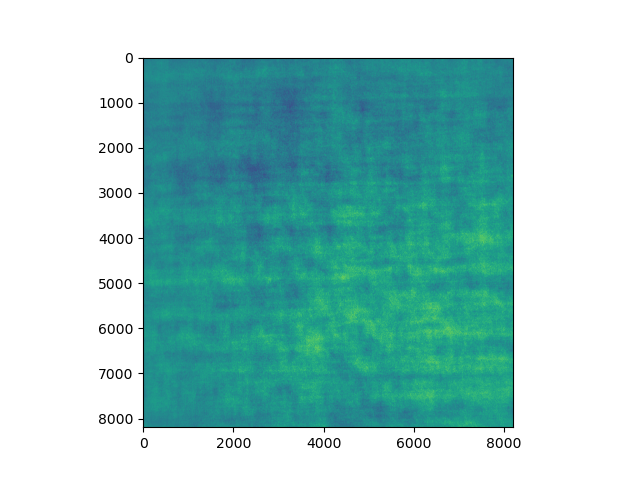

In [21]:
plt.imshow(temp_vol[0,:,:].cpu().detach().numpy())

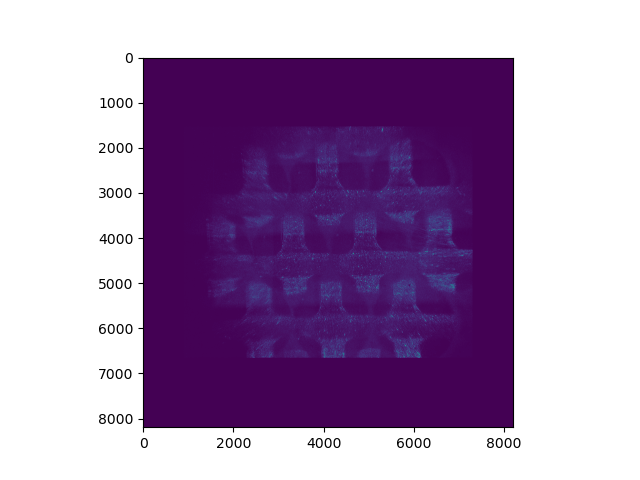

In [8]:
plt.imshow(original_image[0,:,:].cpu().detach().numpy())

In [14]:
plt.imshow(temp_vol1[0,:,:].cpu().detach().numpy())

NameError: name 'temp_vol1' is not defined

In [20]:
plt.close()